## Bitcoint price training with MLP

In [1]:
import pandas as pd

data = pd.read_json('btc_usd.json')

In [2]:
from datetime import datetime

def convertTimeStampToUTC(data):
  return datetime.fromtimestamp(data)
data['timeUTC'] = data['time'].apply(convertTimeStampToUTC)
data

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timeUTC
0,1638252000,56617.65,55931.33,56352.01,1858.44,1.045344e+08,56598.74,direct,,2021-11-30 13:00:00
1,1638255600,56814.98,56280.01,56598.74,955.75,5.402254e+07,56549.97,direct,,2021-11-30 14:00:00
2,1638259200,57401.48,56306.77,56549.97,1640.85,9.322779e+07,56847.66,direct,,2021-11-30 15:00:00
3,1638262800,56977.73,56391.09,56847.66,1182.52,6.696356e+07,56784.82,direct,,2021-11-30 16:00:00
4,1638266400,57270.91,56638.16,56784.82,1068.45,6.086561e+07,57198.35,direct,,2021-11-30 17:00:00
...,...,...,...,...,...,...,...,...,...,...
4000,1652652000,31406.35,31042.01,31043.23,2027.81,6.321219e+07,31052.26,direct,,2022-05-16 05:00:00
4001,1652655600,31328.24,31011.68,31052.26,1355.04,4.221406e+07,31296.11,direct,,2022-05-16 06:00:00
4002,1652659200,31296.19,31011.04,31296.11,1650.66,5.133903e+07,31074.14,direct,,2022-05-16 07:00:00
4003,1652662800,31109.50,30651.61,31074.14,2127.79,6.561553e+07,30722.98,direct,,2022-05-16 08:00:00


In [3]:
data = data.set_index(data['timeUTC'])['close']
data

timeUTC
2021-11-30 13:00:00    56598.74
2021-11-30 14:00:00    56549.97
2021-11-30 15:00:00    56847.66
2021-11-30 16:00:00    56784.82
2021-11-30 17:00:00    57198.35
                         ...   
2022-05-16 05:00:00    31052.26
2022-05-16 06:00:00    31296.11
2022-05-16 07:00:00    31074.14
2022-05-16 08:00:00    30722.98
2022-05-16 09:00:00    30382.83
Name: close, Length: 4005, dtype: float64

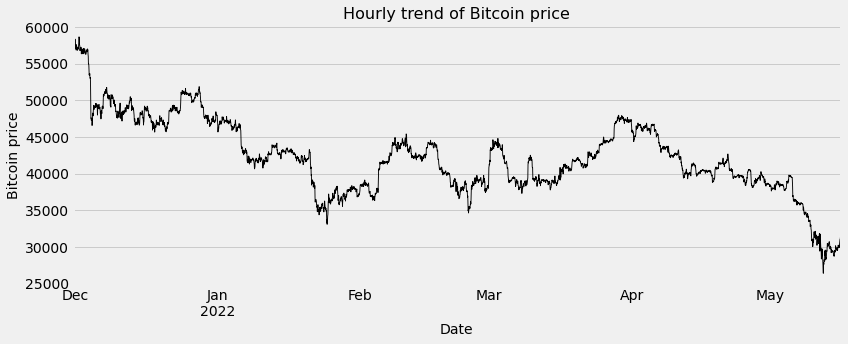

In [4]:
import matplotlib.pyplot as plt

# plot the data
with plt.style.context('fivethirtyeight'):
    data.plot(figsize=(12,5),style='k-',linewidth=.9,legend=False)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Bitcoin price',fontsize=14)
    plt.title('Hourly trend of Bitcoin price',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

In [5]:
import numpy as np

data = data.values
max_value = 60000
s = data/max_value

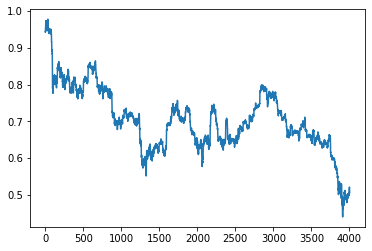

In [6]:
plt.plot(s)

In [7]:
input_size = 32
overlap_size = 24
predict_distance = 5-1

# s = np.linspace(0,999,1000)
samples = int((len(s)-input_size)/(input_size-overlap_size))
X = np.stack([s[i*(input_size-overlap_size) : i*(input_size-overlap_size) + input_size] for i in range(int(samples))])
y = np.stack([s[i*(input_size-overlap_size) + input_size + predict_distance] for i in range(int(samples))])

In [8]:
print('X shape =',X.shape)
print('y shape =',y.shape)

X shape = (496, 32)
y shape = (496,)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [10]:
print(X_train.shape)
print(y_train.shape)

(446, 32)
(446,)


In [11]:
import tensorflow as tf

# định nghĩa thuật toán tối ưu
optimizer = tf.keras.optimizers.SGD(learning_rate=0.002)

# xây dựng mô hình
def create_model():
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.Input(shape=(32,)))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer=optimizer,
                  loss='mse')

    return model

In [12]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2

2022-05-18 10:36:49.158518: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
weights_filepath = './weights/'
callback = tf.keras.callbacks.ModelCheckpoint( filepath = weights_filepath, monitor='val_loss', \
                                              verbose=1, save_best_only=True, save_weights_only=False)
his = model.fit(X, y, epochs = 150, batch_size = 32, validation_split=0.2, \
                shuffle=True, callbacks = callback)

Epoch 1/150
 1/13 [=>............................] - ETA: 4s - loss: 0.0329
Epoch 1: val_loss improved from inf to 0.01116, saving model to ./weights/


2022-05-18 10:36:50.135173: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./weights/assets
13/13 [==============================] - 2s 104ms/step - loss: 0.0341 - val_loss: 0.0112
Epoch 2/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0351
Epoch 2: val_loss improved from 0.01116 to 0.00976, saving model to ./weights/
INFO:tensorflow:Assets written to: ./weights/assets
13/13 [==============================] - 1s 66ms/step - loss: 0.0308 - val_loss: 0.0098
Epoch 3/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0264
Epoch 3: val_loss improved from 0.00976 to 0.00853, saving model to ./weights/
INFO:tensorflow:Assets written to: ./weights/assets
13/13 [==============================] - 1s 68ms/step - loss: 0.0285 - val_loss: 0.0085
Epoch 4/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0243
Epoch 4: val_loss improved from 0.00853 to 0.00746, saving model to ./weights/
INFO:tensorflow:Assets written to: ./weights/assets
13/13 [==============================] - 1s 73ms/step - loss: 

Epoch 34/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0060
Epoch 34: val_loss did not improve from 0.00309
13/13 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0046
Epoch 35/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0064
Epoch 35: val_loss did not improve from 0.00309
13/13 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 36/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0047
Epoch 36: val_loss did not improve from 0.00309
13/13 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 37/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0036
Epoch 37: val_loss did not improve from 0.00309
13/13 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 38/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0045
Epoch 38: val_loss did not improve from 0.00309
13/13 [====================

Epoch 73/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0072
Epoch 73: val_loss did not improve from 0.00309
13/13 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0070
Epoch 74/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0053
Epoch 74: val_loss did not improve from 0.00309
13/13 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0070
Epoch 75/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0048
Epoch 75: val_loss did not improve from 0.00309
13/13 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 76/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0066
Epoch 76: val_loss did not improve from 0.00309
13/13 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0071
Epoch 77/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0040
Epoch 77: val_loss did not improve from 0.00309
13/13 [====================

13/13 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0073
Epoch 112/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0055
Epoch 112: val_loss did not improve from 0.00309
13/13 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0074
Epoch 113/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0052
Epoch 113: val_loss did not improve from 0.00309
13/13 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0073
Epoch 114/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0058
Epoch 114: val_loss did not improve from 0.00309
13/13 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0073
Epoch 115/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0057
Epoch 115: val_loss did not improve from 0.00309
13/13 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0073
Epoch 116/150
 1/13 [=>............................] - ET

Epoch 150/150
 1/13 [=>............................] - ETA: 0s - loss: 0.0052
Epoch 150: val_loss did not improve from 0.00309
13/13 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0073


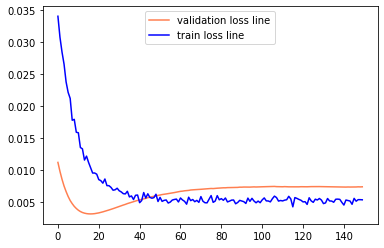

In [14]:
plt.plot(his.history['val_loss'], c = 'coral', label = 'validation loss line')
plt.plot(his.history['loss'], c = 'blue', label = 'train loss line')
legend = plt.legend(loc='upper center')
plt.show()
